In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm
from scipy.integrate import simpson

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


np.set_printoptions(linewidth=np.inf)

#### parallelization 
options = qt.Options(num_cpus=6)


# Plotting setup

In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    "font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

# Geting eigenspectrum

In [3]:


def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

# Entropy current observable 

In [4]:
def heat_current_1(t, jump, args):
    ### if hot bath

    if jump == 0:  # |0><1| 
        return -(args["omega"] - args["Omega"])
    elif jump == 1:# |1><0|
        return (args["omega"] - args["Omega"])
    elif jump == 2:# |0><2|
        return -(args["omega"] + args["Omega"])
    elif jump == 3:# |2><0|
        return (args["omega"] + args["Omega"])
    elif jump == 4:# |1><3|
        return -(args["omega"] + args["Omega"])
    elif jump == 5:# |3><1|
        return (args["omega"] + args["Omega"])
    elif jump == 6:# |2><3|
        return -(args["omega"] - args["Omega"])
    elif jump == 7:# |3><2|
        return (args["omega"] - args["Omega"])
    else: 
        return 0
    ### if cold bath

def heat_current_2(t, jump, args):

    if jump == 8:# |0><1|
        return -(args["omega"] - args["Omega"])
    elif jump == 9:# |1><0|
        return (args["omega"]  - args["Omega"])
    elif jump == 10:# |0><2|
        return -(args["omega"] + args["Omega"])
    elif jump == 11:# |2><0|
        return (args["omega"] + args["Omega"])
    elif jump == 12:# |1><3|
        return -(args["omega"] + args["Omega"])
    elif jump == 13:# |3><1|
        return (args["omega"] + args["Omega"])
    elif jump == 14:# |2><3|
        return -(args["omega"] - args["Omega"])
    elif jump == 15:# |3><2|
        return (args["omega"] - args["Omega"])
    else:
        return 0 

def heat_current(t, jump, args):
    if jump == 0:  # |0><1| 
        return -(args["omega"] - args["Omega"])
    elif jump == 1:# |1><0|
        return (args["omega"] - args["Omega"])
    elif jump == 2:# |0><2|
        return -(args["omega"] + args["Omega"])
    elif jump == 3:# |2><0|
        return (args["omega"] + args["Omega"])
    elif jump == 4:# |1><3|
        return -(args["omega"] + args["Omega"])
    elif jump == 5:# |3><1|
        return (args["omega"] + args["Omega"])
    elif jump == 6:# |2><3|
        return -(args["omega"] - args["Omega"])
    elif jump == 7:# |3><2|
        return (args["omega"] - args["Omega"])
    ### if cold bath

    elif jump == 8:# |0><1|
        return -(args["omega"] - args["Omega"])
    elif jump == 9:# |1><0|
        return (args["omega"]  - args["Omega"])
    elif jump == 10:# |0><2|
        return -(args["omega"] + args["Omega"])
    elif jump == 11:# |2><0|
        return (args["omega"] + args["Omega"])
    elif jump == 12:# |1><3|
        return -(args["omega"] + args["Omega"])
    elif jump == 13:# |3><1|
        return (args["omega"] + args["Omega"])
    elif jump == 14:# |2><3|
        return -(args["omega"] - args["Omega"])
    elif jump == 15:# |3><2|
        return (args["omega"] - args["Omega"])
    else:
        return 0 

def Trott_organize_jumps(col_times, col_which, Nboxes, args, which="1"):
    # Initialize empty array
    dt = args["tau"]/(Nboxes-1)
    
    current = [0 for _ in range(Nboxes)]
    
    # Organize time instants into arrays
    if which == "1":
        for i, col_list in enumerate(col_which):
            for j, col in enumerate(col_list):
                current[i] += heat_current_1(col_times[i][j], col, args)
                
    elif which == "2":
        for i, col_list in enumerate(col_which):
            for j, col in enumerate(col_list):
                current[i] += heat_current_2(col_times[i][j], col, args)
                    
    elif which == "Hc":
        for i, col_list in enumerate(col_which):
            for j, col in enumerate(col_list):
                current[i] += heat_current(col_times[i][j], col, args)
    else: 
        print("Wrong value")
        
    return np.array(current)/dt

# Jumping rates 

In [5]:
########## Rates 

##### hot bath
def J_01_h_rate(t, args): 
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))) ) 
    
def J_10_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
    
##### cold bath
    
def J_01_c_rate(t, args): 
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))) ) 

def J_10_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
    


# Superoperator

In [6]:
def DualSuperOperator_Lindbladian(O, t, H0, cops, args):
    """
        Code for checking if the left eigenmatrix is the actual one 
    """
    omega = args["omega"]
    Omega = args["Omega"]

    bh = args["beta_h"](t, args)
    bc = args["beta0_c"]

    #####
    H0 = Hamiltonian(t, args)

    dO = 1.0j*( H0 * O - O * H0)
    
    for i, c in enumerate(cops):
        dO += (np.exp(-args["s_func"](t, args)*heat_current(t, i, args)) * c.dag() * O * c 
               -  0.5 * (c.dag() * c * O + O * c.dag() * c) )
    return dO 

In [7]:
#Ls = Tilted_lindbladian(args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)
#lambda0, l0 = Numeric_diagonalization(Ls, side="left")

#ll0 = DualSuperOperator_Lindbladian(np.conjugate(l0), args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)


In [8]:
def Tilted_lindbladian(t, H0, cops, args):

    """
        Evaluate the vectorize tilted Lindbladian at time $t$
    """
    
    omega = args["omega"]
    Omega = args["Omega"]
    s = args["s_func"](t, args)
    bh = args["beta_h"](t, args)
    bc = args["beta0_c"]

    ####
    H0 = Hamiltonian(t, args)
    
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()
     
    J_01_h, J_10_h, J_02_h, J_20_h, J_13_h, J_31_h, J_23_h, J_32_h = cops[0:8]
    J_01_c, J_10_c, J_02_c, J_20_c, J_13_c, J_31_c, J_23_c, J_32_c = cops[8:]
    
    ########### Flattening the operators 
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    ####### Non-hermitian evolution 
    ## hot bath
    
    Flat_J_01_h = -(1.0/2.0)*(qt.tensor(Ide, J_01_h.dag()*J_01_h) + qt.tensor((J_01_h.dag()*J_01_h).trans(), Ide)).full()
    Flat_J_02_h = -(1.0/2.0)*(qt.tensor(Ide, J_02_h.dag()*J_02_h) + qt.tensor((J_02_h.dag()*J_02_h).trans(), Ide)).full()
    Flat_J_13_h = -(1.0/2.0)*(qt.tensor(Ide, J_13_h.dag()*J_13_h) + qt.tensor((J_13_h.dag()*J_13_h).trans(), Ide)).full()
    Flat_J_23_h = -(1.0/2.0)*(qt.tensor(Ide, J_23_h.dag()*J_23_h) + qt.tensor((J_23_h.dag()*J_23_h).trans(), Ide)).full()

    Flat_J_10_h = -(1.0/2.0)*(qt.tensor(Ide, J_10_h.dag()*J_10_h) + qt.tensor((J_10_h.dag()*J_10_h).trans(), Ide)).full()
    Flat_J_20_h = -(1.0/2.0)*(qt.tensor(Ide, J_20_h.dag()*J_20_h) + qt.tensor((J_20_h.dag()*J_20_h).trans(), Ide)).full()
    Flat_J_31_h = -(1.0/2.0)*(qt.tensor(Ide, J_31_h.dag()*J_31_h) + qt.tensor((J_31_h.dag()*J_31_h).trans(), Ide)).full()
    Flat_J_32_h = -(1.0/2.0)*(qt.tensor(Ide, J_32_h.dag()*J_32_h) + qt.tensor((J_32_h.dag()*J_32_h).trans(), Ide)).full()

    ## cold bath
    Flat_J_01_c = -(1.0/2.0)*(qt.tensor(Ide, J_01_c.dag()*J_01_c) + qt.tensor((J_01_c.dag()*J_01_c).trans(), Ide)).full()
    Flat_J_02_c = -(1.0/2.0)*(qt.tensor(Ide, J_02_c.dag()*J_02_c) + qt.tensor((J_02_c.dag()*J_02_c).trans(), Ide)).full()
    Flat_J_13_c = -(1.0/2.0)*(qt.tensor(Ide, J_13_c.dag()*J_13_c) + qt.tensor((J_13_c.dag()*J_13_c).trans(), Ide)).full()
    Flat_J_23_c = -(1.0/2.0)*(qt.tensor(Ide, J_23_c.dag()*J_23_c) + qt.tensor((J_23_c.dag()*J_23_c).trans(), Ide)).full()

    Flat_J_10_c = -(1.0/2.0)*(qt.tensor(Ide, J_10_c.dag()*J_10_c) + qt.tensor((J_10_c.dag()*J_10_c).trans(), Ide)).full()
    Flat_J_20_c = -(1.0/2.0)*(qt.tensor(Ide, J_20_c.dag()*J_20_c) + qt.tensor((J_20_c.dag()*J_20_c).trans(), Ide)).full()
    Flat_J_31_c = -(1.0/2.0)*(qt.tensor(Ide, J_31_c.dag()*J_31_c) + qt.tensor((J_31_c.dag()*J_31_c).trans(), Ide)).full()
    Flat_J_32_c = -(1.0/2.0)*(qt.tensor(Ide, J_32_c.dag()*J_32_c) + qt.tensor((J_32_c.dag()*J_32_c).trans(), Ide)).full()

    
    Flat_Inc_h = (Flat_J_01_h + Flat_J_02_h + Flat_J_13_h + Flat_J_23_h
                + Flat_J_10_h + Flat_J_20_h + Flat_J_31_h + Flat_J_32_h)

    Flat_Inc_c = (Flat_J_01_c + Flat_J_02_c + Flat_J_13_c + Flat_J_23_c
                + Flat_J_10_c + Flat_J_20_c + Flat_J_31_c + Flat_J_32_c)

    ####### Jumps 
    # hot bath
    Flat_jump_J_01_h = (qt.tensor(J_01_h.conj(),J_01_h)).full()
    Flat_jump_J_02_h = (qt.tensor(J_02_h.conj(),J_02_h)).full()
    Flat_jump_J_13_h = (qt.tensor(J_13_h.conj(),J_13_h)).full()
    Flat_jump_J_23_h = (qt.tensor(J_23_h.conj(),J_23_h)).full()

    Flat_jump_J_10_h = (qt.tensor(J_10_h.conj(),J_10_h)).full()
    Flat_jump_J_20_h = (qt.tensor(J_20_h.conj(),J_20_h)).full()
    Flat_jump_J_31_h = (qt.tensor(J_31_h.conj(),J_31_h)).full()
    Flat_jump_J_32_h = (qt.tensor(J_32_h.conj(),J_32_h)).full()
    
    #cold bath
    Flat_jump_J_01_c = (qt.tensor(J_01_c.conj(),J_01_c)).full()
    Flat_jump_J_02_c = (qt.tensor(J_02_c.conj(),J_02_c)).full()
    Flat_jump_J_13_c = (qt.tensor(J_13_c.conj(),J_13_c)).full()
    Flat_jump_J_23_c = (qt.tensor(J_23_c.conj(),J_23_c)).full()

    Flat_jump_J_10_c = (qt.tensor(J_10_c.conj(),J_10_c)).full()
    Flat_jump_J_20_c = (qt.tensor(J_20_c.conj(),J_20_c)).full()
    Flat_jump_J_31_c = (qt.tensor(J_31_c.conj(),J_31_c)).full()
    Flat_jump_J_32_c = (qt.tensor(J_32_c.conj(),J_32_c)).full()

    Flat_Jump_h = (  np.exp(+s*(omega-Omega))*Flat_jump_J_01_h 
                   + np.exp(+s*(omega+Omega))*Flat_jump_J_02_h 
                   + np.exp(+s*(omega+Omega))*Flat_jump_J_13_h 
                   + np.exp(+s*(omega-Omega))*Flat_jump_J_23_h

                   + np.exp(-s*(omega-Omega))*Flat_jump_J_10_h 
                   + np.exp(-s*(omega+Omega))*Flat_jump_J_20_h 
                   + np.exp(-s*(omega+Omega))*Flat_jump_J_31_h 
                   + np.exp(-s*(omega-Omega))*Flat_jump_J_32_h)

    Flat_Jump_c = (  np.exp(+s*(omega-Omega))*Flat_jump_J_01_c 
                   + np.exp(+s*(omega+Omega))*Flat_jump_J_02_c 
                   + np.exp(+s*(omega+Omega))*Flat_jump_J_13_c 
                   + np.exp(+s*(omega-Omega))*Flat_jump_J_23_c

                   + np.exp(-s*(omega-Omega))*Flat_jump_J_10_c 
                   + np.exp(-s*(omega+Omega))*Flat_jump_J_20_c 
                   + np.exp(-s*(omega+Omega))*Flat_jump_J_31_c 
                   + np.exp(-s*(omega-Omega))*Flat_jump_J_32_c)

    Lst = Flat_H0 + Flat_Inc_h + Flat_Jump_h + Flat_Inc_c + Flat_Jump_c     

    return Lst.astype(complex)




# Geting the Doob auxilary system

In [9]:
def Doob_system(H0, c_ops, t, args):
    """
        Evaluate the auxiliary doob Hamiltonian 
    """
    #### Tilted Lindbladian 
    Ls = Tilted_lindbladian(t, H0, c_ops, args)
    lambda0, l0 = Numeric_diagonalization(Ls, side="left")
    
    #### Non-hermitian term of the deterministic evolution
    
    Heff = Hamiltonian(t, args)
    
    for c in c_ops:
        Heff -= 0.5j * c.dag() * c
            
    #### Calculating the Doob

    l0sqr = qt.Qobj(l0, dims=[[2, 2], [2, 2]]).sqrtm()
    Heff = l0sqr * Heff * l0sqr.inv()

    Heff = 0.5*(Heff + Heff.dag())
    Jauxlist = []
    for j, c in enumerate(c_ops):
        rotated_operator = l0sqr*c*l0sqr.inv()
        rotated_rate = np.exp(-args["s_func"](t, args)*heat_current(t, j, args)/2)
        Jauxlist.append(rotated_rate*rotated_operator)
            
    return Heff, Jauxlist

# Geting one trajectory 

In [10]:
def OneTrajectory(H0, c_ops, psi, tlist, args):
    """
        Computates one trajectory of the adiabatic evolution
        using the method of deviting the interval in $N$ subintervals, not at $dt$. 
    """
    jumps = []
    times = []

    dt = tlist[1]-tlist[0]
    for i, t in enumerate(tlist):
        print("Time interval {} + {} \n".format(t, dt))
        aux_tlist = np.linspace((i+1)*dt, (i+2)*dt, 1000)
        aux_c_ops = [j[0]*(j[1](t, args)) for j in c_ops]
        Haux, Jaux = Doob_system(Hamiltonian(t, args), aux_c_ops, t, args)
        result = qt.mcsolve(Haux, psi, aux_tlist, Jaux, args=args, ntraj=1)

        jumps.append(result.col_which[0])
        times.append(result.col_times[0])

        psi = result.states[0][-1]
    return jumps, times

# Geting the SCGF 

Theory prediction

In [11]:
############# Get scaled cumulant generating function

def f(H0, cops, tlist, slist, args):
    """
        Evaluate a grid of the SCFG in (s(t), t)
    """
    grid = np.zeros((len(tlist), len(slist)))

    for i, t in enumerate(tlist):
        aux_cops = [c[0]*c[1](t, args) for c in cops]
        for j, s in enumerate(slist):
            args_copy = args.copy()
            args_copy["s_func"] = lambda t, args: s
            
            e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, Hamiltonian(t, args), aux_cops, args_copy), side="right")
            grid[i][j] = np.real(e_val)
            
    return grid.real  

############# Get activities for a trajectory

def get_activities(H0, cops, Slen, s0, sf, Tlen, args):
    """
        Evaluate a grid of the derivative of SCFG in (s(t), t)
    """
    # Compute the Legendre transform for each 

    grid = f(H0, c_ops_list, tlist=np.linspace(0, args["tau"], Tlen),
                             slist=np.linspace(s0, sf, Slen),
                             args=args)
    
    return -np.gradient(grid, np.linspace(s0, sf, Slen),  edge_order=2, axis=1)

############# Evaluating the SCGF in the path

def get_qs_path(activities, Tlen, Slen, s0, sf, args):
    """
        Get the value of the SCGF at s(t)
    """
    
    slist_aux = np.linspace(s0, sf, Slen)
    tlist_aux = np.linspace(0, args["tau"], Tlen)

    qs_values = []
    for i, t in enumerate(tlist_aux):
        qs_values.append(np.interp(args["s_func"](t, args),  slist_aux, activities[i] ))
    return qs_values

# Defining Hamiltonian and operators

In [12]:
####### Hamiltonian    

def Hamiltonian(t, args):
    
    H0 = (args["Omega"]*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
        + args["g_t"](t, args)*(sigmax_c + sigmax_h) 
        + (args["omega"]/2)*(sigmaz_c + sigmaz_h))
    return H0
####### Initial state

In [13]:
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    
##### Transitions 
    
J_01 = eps0 * eps1.dag()
    
J_10 = eps1 * eps0.dag() 
        
J_02 = eps0 * eps2.dag()
    
J_20 = eps2 * eps0.dag()
    
J_13 = eps1 * eps3.dag()

J_31 = eps3 * eps1.dag()

J_23 = eps2 * eps3.dag()
    
J_32 = eps3 * eps2.dag()


In [14]:
#####
# Putting it into a list 
    
c_ops_list = [[J_01, J_01_h_rate], 
             [J_10, J_10_h_rate],
             [J_02, J_02_h_rate],  
             [J_20, J_20_h_rate],
             [J_13, J_13_h_rate],
             [J_31, J_31_h_rate], 
             [J_23, J_23_h_rate], 
             [J_32, J_32_h_rate], 
#####################################
             [J_01, J_01_c_rate],
             [J_10, J_10_c_rate], 
             [J_02, J_02_c_rate],
             [J_20, J_20_c_rate],
             [J_13, J_13_c_rate],
             [J_31, J_31_c_rate],
             [J_23, J_23_c_rate],
             [J_32, J_32_c_rate]]


In [16]:
####### Parameters 

omega = 1.0
alpha_h = 1.0
alpha_c = 1.0
beta0_h = 1.0/(2.0) # T = 2
beta_c = 1.0/(1.0) # T = 1
Omega = 0.5
g = 2.0

def s_func_t(t, args):
    return 0.5*np.tanh(10*t/args["tau"] - 5)

def s_func_0(t, args):
    return 0*t

def beta_h(t, args):
    return args["beta0_h"]#/(1 + 0.5*np.sin(t*np.pi/args["tau"])**2)

def g_t(t, args):
    if t/args["tau"] < 1/2:
        return 2*args["g"]*t/args["tau"]
    else:
        return 2*args["g"]*(1-t/args["tau"])
    #return args["g"]*(np.sin(t*np.pi/args["tau"])**2)

############# Total dynamics time


tau = 500*1000

############# Argumets dict 

args_st  = {"omega":omega,
            "Omega":Omega,
            "g":g,
            "g_t":g_t,
            "alpha_h":alpha_h,
            "alpha_c":alpha_c,
            "beta_h":beta_h,
            "beta0_h":beta0_h,
            "beta0_c":beta_c,
            "tau":tau,
            "s_func":s_func_t}


args_s0  = {"omega":omega,
            "Omega":Omega,
            "g":g,
            "g_t":g_t,
            "alpha_h":alpha_h,
            "alpha_c":alpha_c,
            "beta_h":beta_h,
            "beta0_h":beta0_h,
            "beta0_c":beta_c,
            "tau":tau,
            "s_func":s_func_0}

#### Parameters for predicting the s-activits'

Slen=1000
s0=-0.5
sf=0.5
Tlen=50

In [17]:


H0 = Hamiltonian(0, args_s0)
psi0 = ket00.copy()

####### Time window 
Nsteps = 100
tlist_traj = np.linspace(0, tau, Nsteps)

# Time-dependent: s(t)

## Trajectory

In [18]:
jumps, times =  OneTrajectory(H0, c_ops_list, psi0, tlist_traj, args_st)

Time interval 0.0 + 5050.50505050505 

Total run time:   5.55s
Time interval 5050.50505050505 + 5050.50505050505 

Total run time:   5.94s
Time interval 10101.0101010101 + 5050.50505050505 

Total run time:   6.86s
Time interval 15151.515151515152 + 5050.50505050505 

Total run time:   6.13s
Time interval 20202.0202020202 + 5050.50505050505 

Total run time:   6.18s
Time interval 25252.52525252525 + 5050.50505050505 

Total run time:   6.19s
Time interval 30303.030303030304 + 5050.50505050505 

Total run time:   6.23s
Time interval 35353.53535353535 + 5050.50505050505 

Total run time:   6.24s
Time interval 40404.0404040404 + 5050.50505050505 

Total run time:   6.38s
Time interval 45454.545454545456 + 5050.50505050505 

Total run time:   6.42s
Time interval 50505.0505050505 + 5050.50505050505 

Total run time:   6.48s
Time interval 55555.555555555555 + 5050.50505050505 

Total run time:   6.54s
Time interval 60606.06060606061 + 5050.50505050505 

Total run time:   6.43s
Time interval 

In [19]:
ent = Trott_organize_jumps(times, jumps, Nsteps, args_st,which="Hc")

## Theory prediction

In [20]:
activities = get_activities(H0=H0, cops=c_ops_list, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

In [21]:
qs_values = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

## Plotting

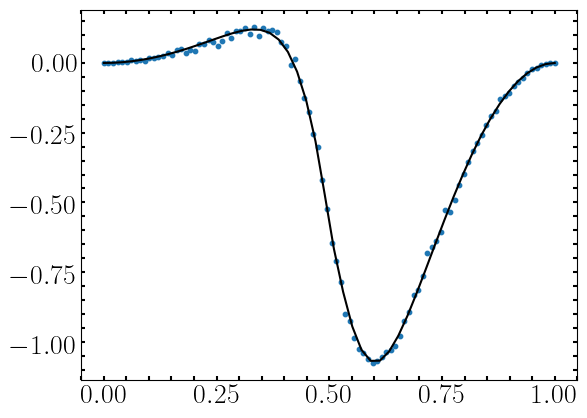

In [22]:
plt.plot(np.linspace(0, 1, Tlen), qs_values, color="black")
plt.scatter(np.linspace(0, 1, len(ent)), ent, s=10)


## Saving 

In [33]:
data_st = args_st.copy()
data_st.update({"jumps":jumps})
data_st.update({"times":times})
data_st.update({"heat":ent})
data_st.update({"SCFG_prediction":qs_values})
data_st.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_st.update({"tlist":np.linspace(0, 1, Tlen)})

del data_st["s_func"]
del data_st["g_t"]
del data_st["beta_h"]

In [34]:
with open('Data_st_heat.pickle', 'wb') as handle:
    pickle.dump(data_st, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()

# Constant path: s = 0

## Trajectory

In [25]:
jumps_s0, times_s0 =  OneTrajectory(H0, c_ops_list, psi0, tlist_traj, args_s0)

Time interval 0.0 + 5050.50505050505 

Total run time:   5.47s
Time interval 5050.50505050505 + 5050.50505050505 

Total run time:   5.93s
Time interval 10101.0101010101 + 5050.50505050505 

Total run time:   5.96s
Time interval 15151.515151515152 + 5050.50505050505 

Total run time:   6.14s
Time interval 20202.0202020202 + 5050.50505050505 

Total run time:   6.17s
Time interval 25252.52525252525 + 5050.50505050505 

Total run time:   6.20s
Time interval 30303.030303030304 + 5050.50505050505 

Total run time:   6.17s
Time interval 35353.53535353535 + 5050.50505050505 

Total run time:   6.27s
Time interval 40404.0404040404 + 5050.50505050505 

Total run time:   6.25s
Time interval 45454.545454545456 + 5050.50505050505 

Total run time:   6.33s
Time interval 50505.0505050505 + 5050.50505050505 

Total run time:   6.31s
Time interval 55555.555555555555 + 5050.50505050505 

Total run time:   6.37s
Time interval 60606.06060606061 + 5050.50505050505 

Total run time:   6.41s
Time interval 

In [26]:
heat_s0= Trott_organize_jumps(times_s0, jumps_s0, Nsteps, args_s0, "Hc")

# Theory prediction

In [27]:
#activities_s0 = get_activities(H0=H0, cops=c_ops_list,  Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)

In [28]:
qs_values_s0 = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)

In [54]:
fluctuation = np.gradient(np.gradient(activities, np.linspace(s0, sf, Slen),  edge_order=2, axis=1), np.linspace(s0, sf, Slen),  edge_order=2, axis=1)

qs_values_s0_fluctuation = get_qs_path(fluctuation, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)



## Plotting

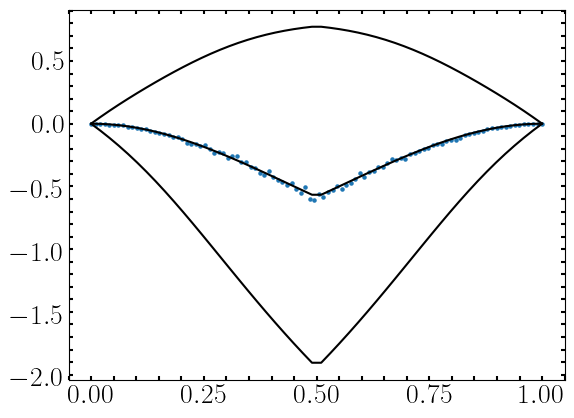

In [58]:
plt.scatter(np.linspace(0, 1, Nsteps), heat_s0, s=5)

plt.plot(np.linspace(0, 1, Tlen), qs_values_s0, color="black")

plt.plot(np.linspace(0, 1, Tlen), np.array(qs_values_s0) - np.sqrt(-np.array(qs_values_s0_fluctuation)), color="black")

plt.plot(np.linspace(0, 1, Tlen), np.array(qs_values_s0) + np.sqrt(-np.array(qs_values_s0_fluctuation)), color="black")


In [46]:
len(qs_values_s0)

50

## Saving

In [37]:
data_s0 = args_s0.copy()
data_s0.update({"jumps":jumps_s0})
data_s0.update({"times":times_s0})
data_s0.update({"heat":heat_s0})
data_s0.update({"SCFG_prediction":qs_values_s0})
data_s0.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_s0.update({"tlist":np.linspace(0, 1, Tlen)})

del data_s0["s_func"]
del data_s0["g_t"]
del data_s0["beta_h"]

In [38]:
with open('Data_s0_heat.pickle', 'wb') as handle:
    pickle.dump(data_s0, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Plotting togheter 

(0.0, 1.0)

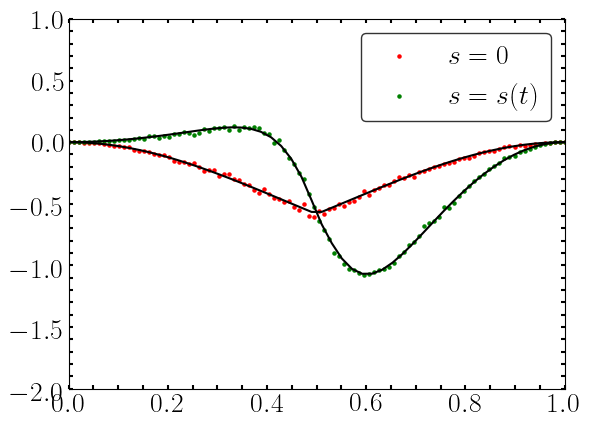

In [36]:
plt.scatter(np.linspace(0, Nsteps, Nsteps)/(Nsteps), heat_s0, s=5, color="red", label=r"$s=0$" )

plt.plot(np.linspace(0, 1, Tlen), qs_values_s0, color="black")

plt.scatter(np.linspace(0, Nsteps, Nsteps)/(Nsteps), ent, s=5, color="green",label=r"$s=s(t)$")

plt.plot(np.linspace(0, 1, Tlen), qs_values, color="black")

plt.legend()

plt.ylim((-2, 1))
plt.xlim((0,1))